In [13]:
from pandas import *
from sklearn.metrics import accuracy_score
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from datetime import datetime
from time import time
import matplotlib.pyplot as plt

In [14]:
print(f'Start @ {datetime.now()}')

Start @ 2024-10-17 21:42:49.404544


In [15]:
data=read_csv('./telecom_churn.csv')
results = {}
# data.shape
# data.head()
# data.dtypes
# data.isna().sum()

In [16]:
data=data.drop(['Unnamed: 0'], axis=1)

Encode 'X' data for feature selection

In [17]:
label_encoder=LabelEncoder()
for col in data.columns:
    data[col]=label_encoder.fit_transform(data[col])
# X.head()
# X.dtypes

In [18]:
X=data.drop(['churn'], axis=1)
y=data['churn']

In [19]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=0)

Feature Selection

In [20]:
rf=RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [21]:
# list(zip(X.columns,rf.feature_importances_))

In [22]:
rfe=RFECV(estimator=rf, cv=5, scoring='accuracy')
rfe.fit(X_train, y_train)

RFECV(cv=5, estimator=RandomForestClassifier(random_state=0),
      scoring='accuracy')

In [23]:
# rfe.get_support()

In [24]:
# list(zip(X_train.columns, rfe.get_support()))

In [25]:
feature_selected=[col_name for col_name, col_vec in list(zip(X_train.columns, rfe.get_support())) if(col_vec == True)]
# feature_selected

In [26]:
# X_train[feature_selected]

Model Classification

In [27]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [28]:
clf_start=time()
print(f'CLF start @ {datetime.now()}')
# Train and evaluate the classifiers
for name, clf in classifiers.items():
    clf.fit(X_train[feature_selected], y_train)  # Train the model
    y_pred = clf.predict(X_test[feature_selected])  # Make predictions on the test set
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[name] = accuracy  # Store the results
clf_end=time()
print(f'CLF end @ {datetime.now()}')

CLF start @ 2024-10-17 21:44:49.822462


c:\Users\Phreaker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CLF end @ 2024-10-17 21:44:54.920753


In [29]:
# Print the accuracy results
print("Classifier Performance:")
for clf_name, accuracy in results.items():
    print(f"{clf_name}: {accuracy:.4f}")
print(f"Time used: {clf_end-clf_start}s")

Classifier Performance:
Logistic Regression: 0.8681
SVM: 0.8771
Random Forest: 0.9535
Gradient Boosting: 0.9565
K-Nearest Neighbors: 0.8681
Time used: 5.0982911586761475s


In [30]:
# variables to plot graph
y_plt=[acc for acc in results.values()]
x_plt=[name for name in results.keys()]

Actual prediction

In [31]:
# Initialize the base classifiers
log_clf = LogisticRegression()
svm_clf = SVC(probability=True)
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()
knn_clf = KNeighborsClassifier()

In [32]:
voting_clf = VotingClassifier(
    estimators=[
        ('log_clf', log_clf),
        ('svm_clf', svm_clf),
        ('rf_clf', rf_clf),
        ('gb_clf', gb_clf),
        ('knn_clf', knn_clf)
    ],
    voting='soft'
)

v_clf_start=time()
print(f'Voting start @ {datetime.now()}')
# Train VotingClassifier
voting_clf.fit(X_train[feature_selected], y_train)

# Make predictions
y_pred_voting = voting_clf.predict(X_test[feature_selected])

print(f'Voting end @ {datetime.now()}')

Voting start @ 2024-10-17 21:44:55.145407


c:\Users\Phreaker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting end @ 2024-10-17 21:45:01.928460


In [33]:
voting_accuracy = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")
v_clf_end=time()
print(f"Voting time: {v_clf_end-v_clf_start}s")
print(f'End @ {datetime.now()}')

Voting Classifier Accuracy: 0.8996
Voting time: 6.83933162689209s
End @ 2024-10-17 21:45:01.984738


Graph for customer churn output

In [34]:
x_data=DataFrame({'churn':y_pred_voting})['churn'].value_counts().sort_index()
y_name=['No(0)','Yes(1)']

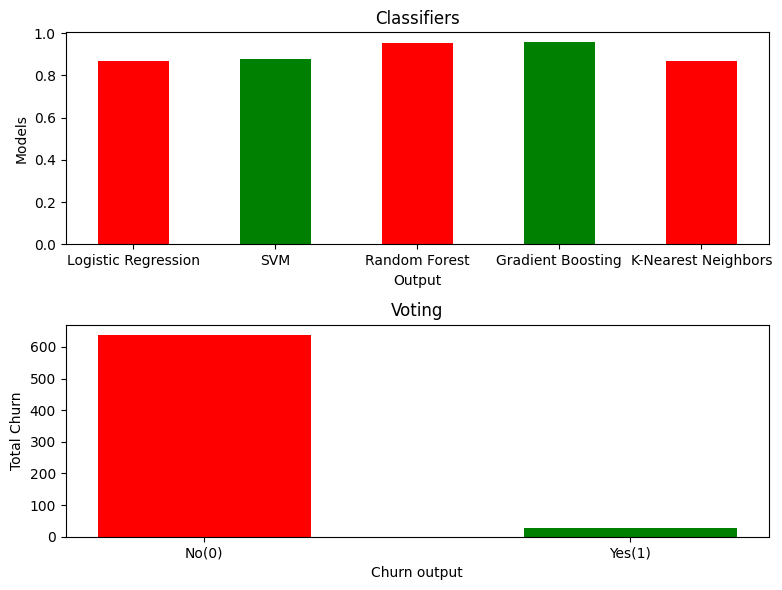

In [36]:
plt.figure(figsize=(8,6))

plt.subplot(211)
plt.bar(x_plt,y_plt,color=['red','green'],width=0.5)
plt.xlabel('Output')
plt.ylabel('Models')
plt.title('Classifiers')

plt.subplot(212)
plt.bar(y_name,x_data,color=['red','green','blue'],width=0.5)
plt.xlabel('Churn output')
plt.ylabel('Total Churn')
plt.title('Voting')

plt.tight_layout()

plt.savefig('OutputImage/figure.png')
plt.show()